In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### 가설 - 가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다.   
"가격 변동성이 크다" 표현 할 수 있는 변수와 "거래량이 몰린" 을 표현하는 변수를 만들어 보겠습니다. 먼저 일봉데이터를 불러옵니다.

In [5]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head()

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
date,,,,,,,,,,,,,,,,,
2021-01-04,2185,2320,2135,2260,588133,0.044,060310,3S,NaN,NaN,0,0.996,1.013,1.013,0.993,0.962,1.013
2021-01-05,2270,2285,2200,2250,410263,-0.004,060310,3S,1.008,0.996,0,1.018,1.018,0.998,0.967,0.971,1.018
2021-01-06,2225,2310,2215,2290,570349,0.018,060310,3S,0.996,1.018,1,1.000,0.980,0.950,0.954,0.950,1.000
2021-01-07,2290,2340,2240,2290,519777,0.000,060310,3S,1.008,1.000,0,0.980,0.950,0.954,0.950,0.959,0.980
2021-01-08,2300,2315,2225,2245,462568,-0.020,060310,3S,0.999,0.980,0,0.969,0.973,0.969,0.978,0.973,0.978


In [ ]:
첫 번째 종목 060310 에 대하여 가격 변동성 변수를 만들어 보겠습니다. 

<AxesSubplot:xlabel='close'>

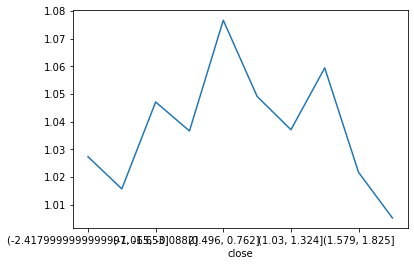

In [17]:
price_mean = mdl_data[mdl_data['code']=='060310']['close'].rolling(60).mean()
price_std = mdl_data[mdl_data['code']=='060310']['close'].rolling(60).std()
price_z = (mdl_data[mdl_data['code']=='060310']['close'] - price_mean)/price_std

ranks = pd.qcut(price_z, q=10)
mdl_data[mdl_data['code']=='060310'].groupby(ranks)['max_close'].mean()

In [20]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all = pd.DataFrame()

for code in kosdaq_list['code']:
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    mdl_data['price_mean'] = mdl_data['close'].rolling(60).mean()
    mdl_data['price_std'] = mdl_data['close'].rolling(60).std()
    mdl_data['price_z'] = (mdl_data['close'] - mdl_data['price_mean'])/mdl_data['price_std']

        # 고가, 저가, 종가 수익율
    for i in [1,2,3,4,5]:

        data['high_r' + str(i)] = data['high'].shift(-1*i)/data['close']      
        data['low_r' + str(i)] = data['low'].shift(-1*i)/data['close']   
        data['close_r' + str(i)] = data['close'].shift(-1*i)/data['close']    
        
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) 
    data.dropna(subset=['price_mean','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True)    
 
    data_all = pd.concat([data, data_all], axis=0)



- #### 가설 - 가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다
4 오분위 수 이상 좋은 수익율을 보여줍니다. 가설은 맞다고 판단됩니다. 하지만 'price_z' 변수나 'volume_z' 변수에 대하여 단조 증가나 감소의 형태를 보여주지는 않습니다. 선형모형으로 데이터를 적합할 경우 입력변수와 타겟변수와의 선형적인 상관관계를 가정으로 하고 있습니다. 따라서, 선형모형의 경우 단조 증가나 단조 감소형태의 모양을 가진 입력변수가 설명력이 좋은 변수입니다. 'price_z' 나 'volume_z' 변수를 선형모형에 활용하기 위해서는 왼쪽 3개의 막대와 오늘쪽 2개의 막대를 각각 묶으면 이 변수가 좀 더 수익율을 잘 설명할 수 있을 것 같습니다. 새롭게 만들어진 변수이름 앞에는 'x_' 를 prefix 로 하도록 하겠습니다.

                 count  mean
ranks                       
(-1.333, 0.447]    105 0.419
(0.447, 1.033]     104 0.413
(1.033, 1.632]     104 0.433
(1.632, 2.174]     104 0.529
(2.174, 5.96]      104 0.510


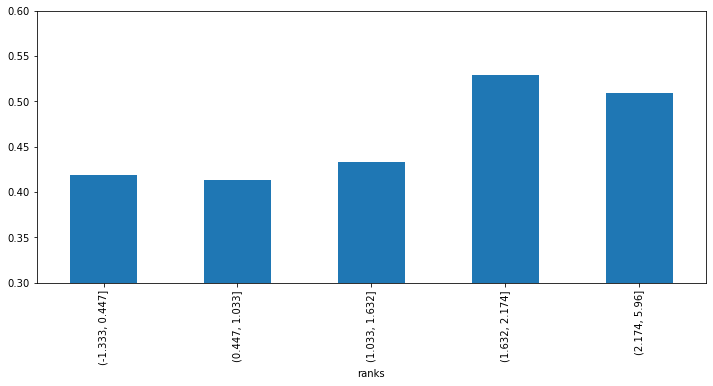

In [71]:
var = 'price_z'
model_data = pd.read_pickle('model_data.pkl')
model_data['target'] = np.where(model_data['return']>1, 1, 0)
model_data['ranks'] = pd.qcut(model_data[var], q = 5)
print(model_data.groupby(['ranks'])['target'].agg(['count', 'mean']))
model_data.groupby('ranks')['target'].mean().plot(kind='bar', figsize=(12,5), ylim=(0.3, 0.6))
plt.show()

x_price_z
0   0.424
1   0.514
Name: target, dtype: float64


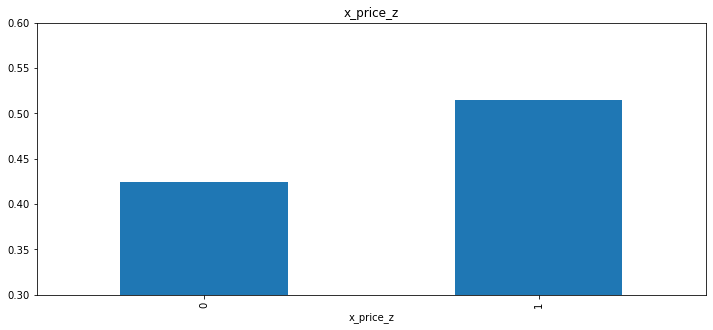

In [72]:
def div(x):
    if x <= 1.63:
        return 0
    else:
        return 1

var = 'x_price_z'
model_data[var] = model_data['price_z'].apply(div)
print(model_data.groupby(var)['target'].mean())
model_data.groupby(var)['target'].mean().plot(kind='bar', figsize=(12,5), ylim=(0.3, 0.6))
plt.title(var)
plt.show()

                  count  mean
ranks                        
(-0.915, -0.433]    105 0.381
(-0.433, -0.324]    104 0.433
(-0.324, -0.15]     104 0.442
(-0.15, 0.253]      104 0.558
(0.253, 7.384]      104 0.490


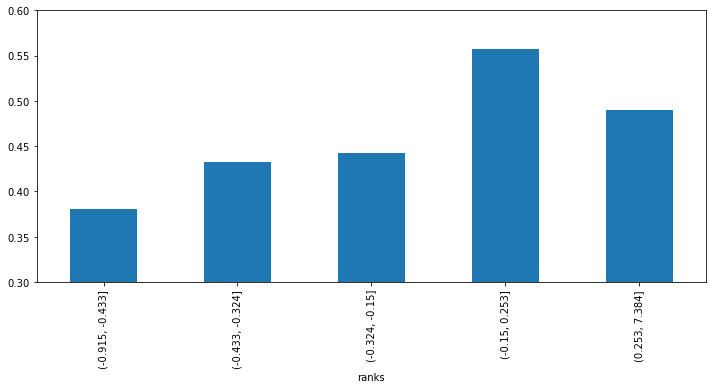

In [73]:
model_data['ranks'] = pd.qcut(model_data['volume_z'], q = 5)
print(model_data.groupby('ranks')['target'].agg(['count', 'mean']))
model_data.groupby('ranks')['target'].mean().plot(kind='bar', figsize=(12,5), ylim=(0.3, 0.6))
plt.show()

x_volume_z
0   0.416
1   0.523
Name: target, dtype: float64


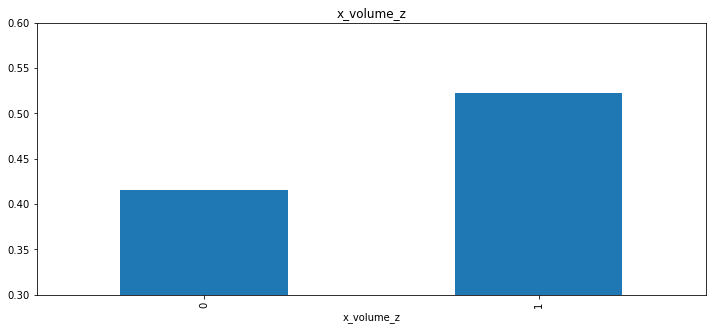

In [74]:
def div(x):
    if x <= -0.176:
        return 0
    else:
        return 1

var = 'x_volume_z'
model_data[var] = model_data['volume_z'].apply(div)
print(model_data.groupby(var)['target'].mean())
model_data.groupby(var)['target'].mean().plot(kind='bar', figsize=(12,5), ylim=(0.3, 0.6))
plt.title(var)
plt.show()